Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading the dataset and checking the first 10 rows to see the data

In [2]:
df = pd.read_csv("health_monitoring_dataset.csv")

print("Initial shape:", df.shape)
df.head()

Initial shape: (300, 10)


,heart_rate,glucose_level,steps,calories,sleep_hours,BMI,smoking_status,alcohol_intake,exercise_hours,stress_level
0,73.285874,101.382034,9270.965850,2108.754861,7.187837,28.113444,non-smoker,4.650197,4.589905,5
1,75.202438,82.001957,4233.504027,1038.106071,6.355892,22.795257,former,1.265740,3.925509,4
2,82.477395,59.184684,9608.817760,2286.527061,7.183446,21.727204,current,1.683767,4.025354,3
3,79.181605,81.978660,11066.913576,2680.895133,7.814947,24.986502,non-smoker,2.392548,0.951066,2
4,69.136441,73.150551,8240.304710,1899.040316,7.073290,NaN,non-smoker,0.308258,4.817916,5


Finding the count of missing values in each column

In [3]:
df.isnull().sum(axis=0)

heart_rate         0
glucose_level      0
steps              0
calories           0
sleep_hours       10
BMI               10
smoking_status     0
alcohol_intake     0
exercise_hours     0
stress_level       0
dtype: int64

Checking each columns' boxplot individually to see unrealistic valuess

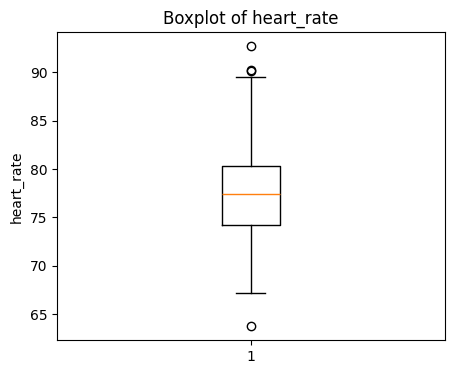

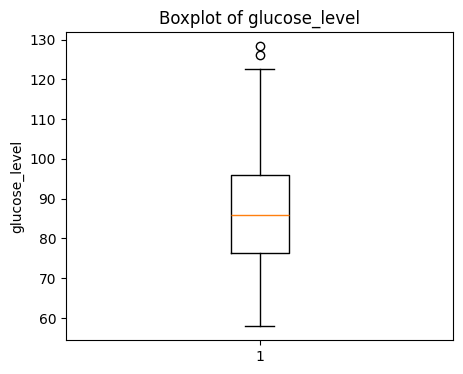

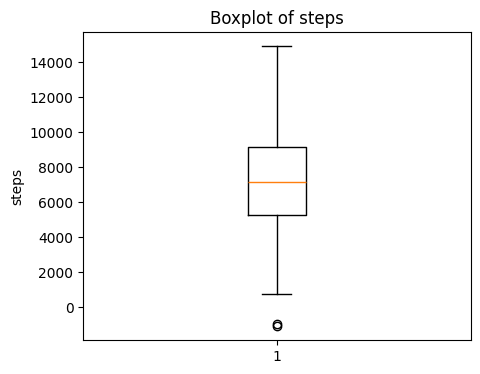

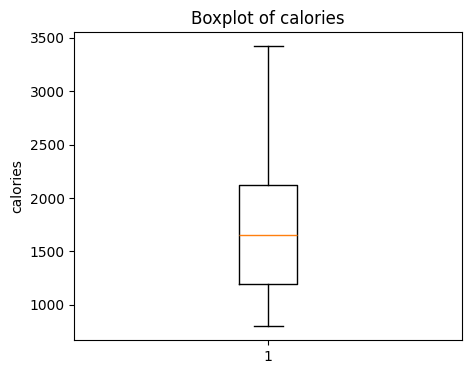

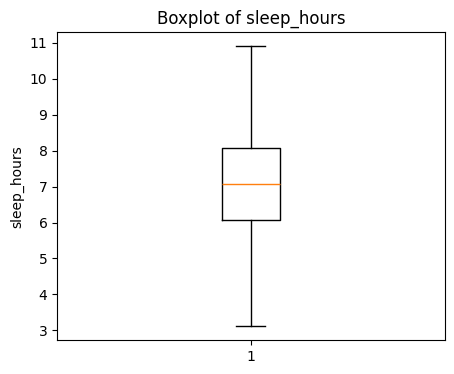

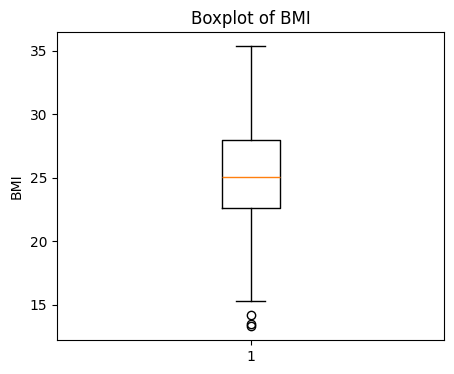

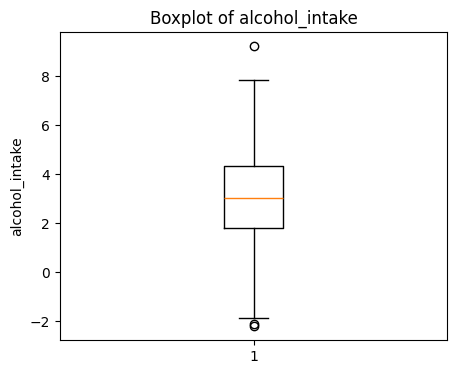

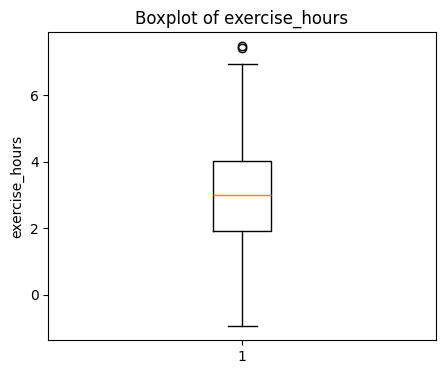

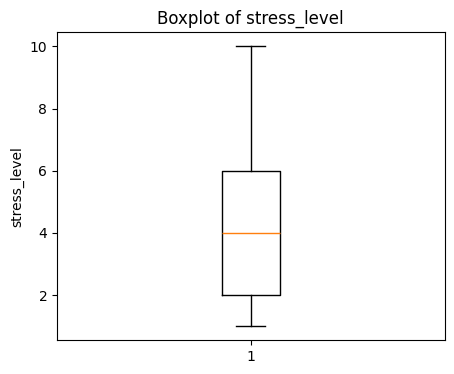

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(5, 4))
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()


Checking stats

In [5]:
df.describe()

,heart_rate,glucose_level,steps,calories,sleep_hours,BMI,alcohol_intake,exercise_hours,stress_level
count,300.000000,300.000000,300.000000,300.000000,290.000000,290.000000,300.000000,300.000000,300.000000
mean,77.517676,86.330823,7246.582359,1699.917839,7.131735,25.184195,3.033794,3.018888,4.190000
std,4.797922,14.563087,2990.029404,638.250709,1.505407,3.896819,1.925259,1.474478,2.588998
min,63.742082,57.925332,-1090.659929,800.000000,3.113437,13.314598,-2.208428,-0.953622,1.000000
25%,74.222309,76.348754,5285.574334,1199.422886,6.081253,22.642178,1.791184,1.924118,2.000000
50%,77.375931,85.829706,7128.221578,1656.509255,7.079132,25.084211,3.033421,3.014245,4.000000
75%,80.361009,95.844126,9134.408751,2125.555064,8.074363,27.953275,4.338353,4.025084,6.000000
max,92.703305,128.299654,14897.146195,3419.876203,10.902525,35.358255,9.219837,7.477889,10.000000


Clean dataset: remove impossible/unrealistic values

In [6]:
# Physiologically realistic hard limits

ranges = {
    "heart_rate": (20, 250),          # medical physiological limits for human heart rate
    "glucose_level": (20, 1500),      # physiologically possible glucose range (very rare extremes allowed)
    "steps": (0, 150000),             # negative steps impossible; 150k allows extreme athletic cases
    "calories": (400, 15000),         # realistic human daily energy expenditure (400–15000 kcal)
    "sleep_hours": (0, 24),           # cannot exceed 24h, zero allowed for rare extreme cases
    "BMI": (8, 100),                  # human physiological extremes, including severe underweight/obesity
    "alcohol_intake": (0, 100),       # negative impossible; 100+ units/day unrealistic even for extreme cases
    "exercise_hours": (0, 24),        # cannot exceed 24h/day; zero allowed
    "stress_level": (0, 10),          # defined scale range
}

# Replace impossible values with NaN
for col, (low, high) in ranges.items():
    if col in df.columns:
        df[col] = df[col].where(df[col].between(low, high))

Let's now get rid of null values using the median of the columns. Why median? Because it is robust to extreme values and outliers, so one outlier will not have an effect to the result of filling missing values

In [7]:
df = df.fillna(df.median(numeric_only=True))

Dropping duplicates (if there are any)

In [8]:
df = df.drop_duplicates()

Extra check for categorical value smoking_status and replacing it with numerical

In [9]:
df['smoking_status'].unique()

array(['non-smoker', 'former', 'current'], dtype=object)

In [10]:
# Map smoking_status from strings to numbers
smoking_map = {
    "non-smoker": 0,
    "former": 1,
    "current": 2
}

df["smoking_status"] = df["smoking_status"].map(smoking_map)

Checking is there any null values left

In [11]:
df.isnull().any().any()

np.False_

Distributions visualizations for the main 5 columns

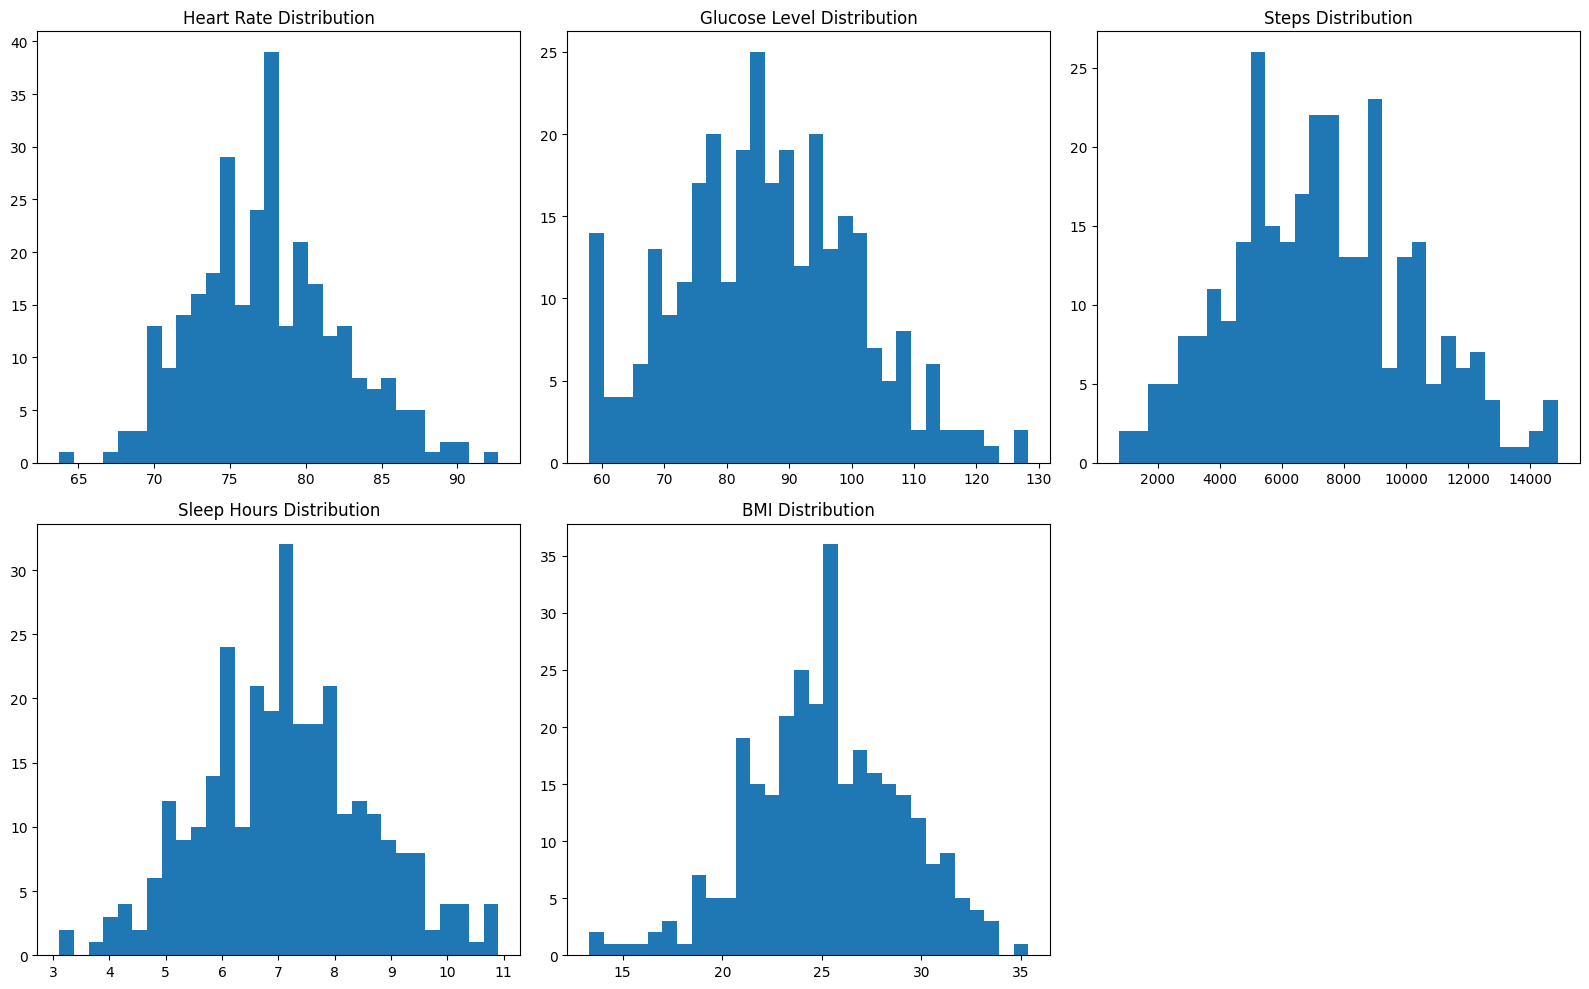

In [12]:
# Visualizations (5)
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.hist(df["heart_rate"], bins=30)
plt.title("Heart Rate Distribution")

plt.subplot(2, 3, 2)
plt.hist(df["glucose_level"], bins=30)
plt.title("Glucose Level Distribution")

plt.subplot(2, 3, 3)
plt.hist(df["steps"], bins=30)
plt.title("Steps Distribution")

plt.subplot(2, 3, 4)
plt.hist(df["sleep_hours"], bins=30)
plt.title("Sleep Hours Distribution")

plt.subplot(2, 3, 5)
plt.hist(df["BMI"], bins=30)
plt.title("BMI Distribution")

plt.tight_layout()
plt.show()

Finding the correlation matrix and creating hypotheses

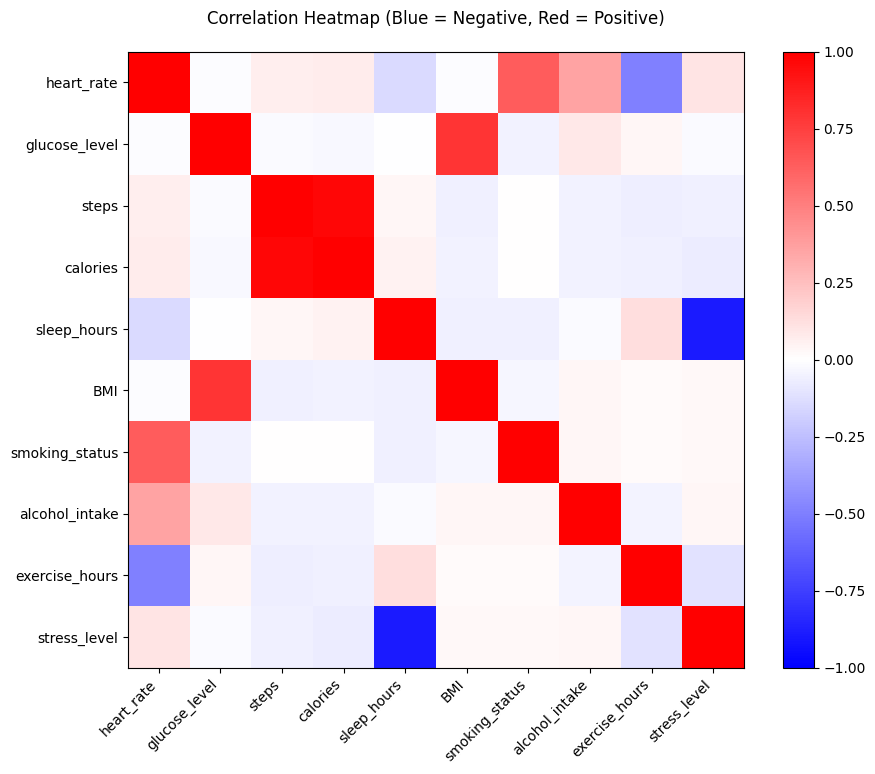

In [13]:
# Define columns
health = [
    "heart_rate",
    "glucose_level",
    "steps",
    "calories",
    "sleep_hours",
    "BMI"
]

lifestyle = [
    "smoking_status",   # categorical - NOT normalize
    "alcohol_intake",
    "exercise_hours",
    "stress_level"
]

# Columns to normalize (exclude smoking_status)
numeric_to_normalize = health + ["alcohol_intake", "exercise_hours", "stress_level"]

# Normalize selected columns in df
df[numeric_to_normalize] = (df[numeric_to_normalize] - df[numeric_to_normalize].mean()) / df[numeric_to_normalize].std()

# Correlation matrix 
corr_matrix = df[health + lifestyle].corr()

# Heatmap 
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="bwr", vmin=-1, vmax=1)

plt.colorbar()

ticks = np.arange(len(corr_matrix.columns))
plt.xticks(ticks, corr_matrix.columns, rotation=45, ha="right")
plt.yticks(ticks, corr_matrix.columns)

plt.title("Correlation Heatmap (Blue = Negative, Red = Positive)", pad=20)
plt.grid(False)

plt.show()


## 📌 Correlation-Based Insights & Hypothesis Development

### 🔍 Key Observations from the Correlation Heatmap

| Feature Relationship                  | Correlation Type | Interpretation                                          |
| ------------------------------------- | ---------------- | ------------------------------------------------------- |
| **steps ⬆ — calories ⬆**              | Strong Positive  | More activity burning more calories                     |
| **glucose_level ⬆ — BMI ⬆**           | Positive         | Higher glucose readings correlate with higher body mass |
| **stress_level ⬆ — sleep_hours ⬇**    | Strong Negative  | Higher stress reduces sleep                             |
| **exercise_hours ⬆ — heart_rate ⬇**   | Negative         | More exercise → lower resting heart rate                |
| **smoking_status ⬆ — heart_rate ⬆**   | Positive         | Smoking elevates heart strain                           |
| **alcohol_intake ⬆ — stress_level ⬆** | Positive         | Alcohol consumption correlates with reported stress     |

---

## 🧪 Hypotheses for Future Predictive Models

| Hypothesis                                                    | Proposed Predictive Direction                     |
| ------------------------------------------------------------- | ------------------------------------------------- |
| Increased physical activity reduces daily calorie surplus     | `steps → calories`                                |
| BMI can be predicted by glucose level and lifestyle variables | `glucose_level + smoking + alcohol → BMI`         |
| Stress level can be predicted from sleep + alcohol + exercise | `sleep_hours + exercise + alcohol → stress_level` |
| Heart rate can be predicted by exercise level and smoking     | `exercise + smoking → heart_rate`                 |

➡ These hypotheses can drive future **Regression, Classification & Time-Series models**.

Saving new cleaned dataset. The output is normalized for the further training

In [14]:
df.to_csv("health_monitoring_cleaned.csv", index=False)

df.head(100)

,heart_rate,glucose_level,steps,calories,sleep_hours,BMI,smoking_status,alcohol_intake,exercise_hours,stress_level
0,-0.882007,1.033518,0.676417,0.640559,0.039090,0.765459,0,0.833511,1.075902,0.312862
1,-0.482550,-0.297249,-1.053455,-1.036915,-0.523017,-0.622688,1,-1.213666,0.606826,-0.073387
2,1.033722,-1.864037,0.792436,0.919089,0.036123,-0.901469,2,-0.960811,0.677318,-0.459637
3,0.346802,-0.298849,1.293149,1.536978,0.462799,-0.050732,0,-0.532087,-1.493191,-0.845887
4,-1.746847,-0.905047,0.322487,0.311982,-0.038304,-0.025228,0,-1.792823,1.236883,0.312862
...,...,...,...,...,...,...,...,...,...,...
95,-0.010982,-0.797526,-0.422332,-0.442181,-0.188045,-1.101443,0,1.637712,0.232439,-0.073387
96,-0.155548,0.884098,0.232548,0.609074,0.843643,0.599235,2,-0.059420,0.264990,-1.232137
97,-1.293513,1.133842,-1.392339,-1.337897,-0.382010,2.100971,0,-1.166929,-0.294847,-0.073387
98,1.059087,-0.658589,0.848501,0.929543,0.183174,-0.025498,1,-0.289566,-0.876634,-0.459637
